In [1]:
import numpy as np
import matplotlib.pyplot as plt

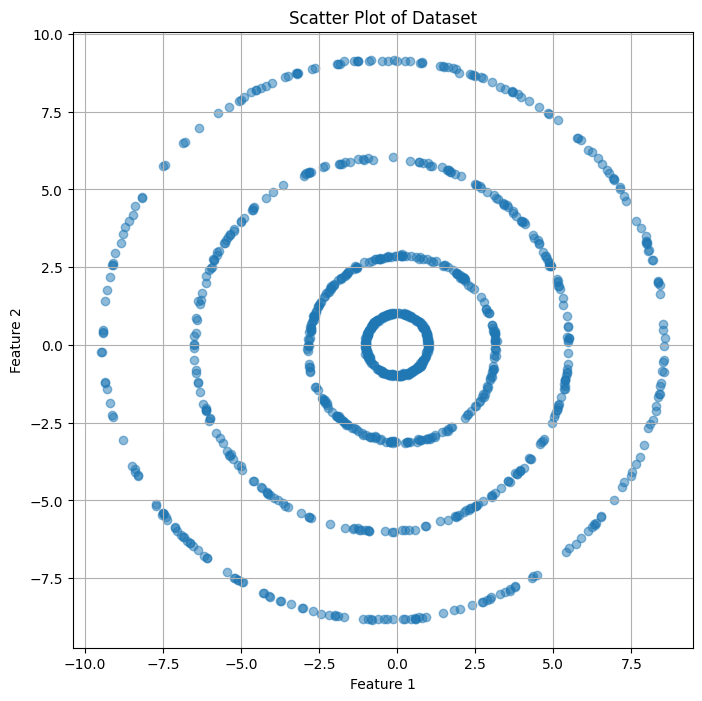

In [2]:
data = np.genfromtxt('dataset2.csv', delimiter=',')

plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Dataset')
plt.grid(True)
plt.show()

# Part A

In [3]:
class KMeansFromScratch:
    def __init__(self, k, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol #tolerance: if all cluster centroids are within tolerance distance from previous iteration, algorithm has converged.

    def fit(self, X, init_seed=None):
        np.random.seed(init_seed)
        # Randomly choose centroids inside data range
        centroids = np.array([np.random.uniform(X.min(axis=0), X.max(axis=0)) for _ in range(self.k)])
        error_history = []
        for _ in range(self.max_iters):
            distances = np.linalg.norm(X[:, None] - centroids, axis=2) # (n, 1, d) - (k, d) = (n, k, d); norm across d-dimension ===> (n, k)
            cluster_ids = np.argmin(distances, axis=1)
            new_centroids = np.array([X[cluster_ids == c].mean(axis=0) if np.any(cluster_ids == c) else centroids[c] for c in range(self.k)])
            error = np.sum((X - new_centroids[cluster_ids]) ** 2)
            error_history.append(error)
            if np.all(np.linalg.norm(new_centroids-centroids, axis=1)<self.tol):
                break
            centroids = new_centroids
        self.centroids = centroids
        self.labels = cluster_ids
        self.error_history = error_history

In [4]:
seeds = np.random.randint(1, 101, size=6)
print(seeds)

[78 71 24 31 93 94]


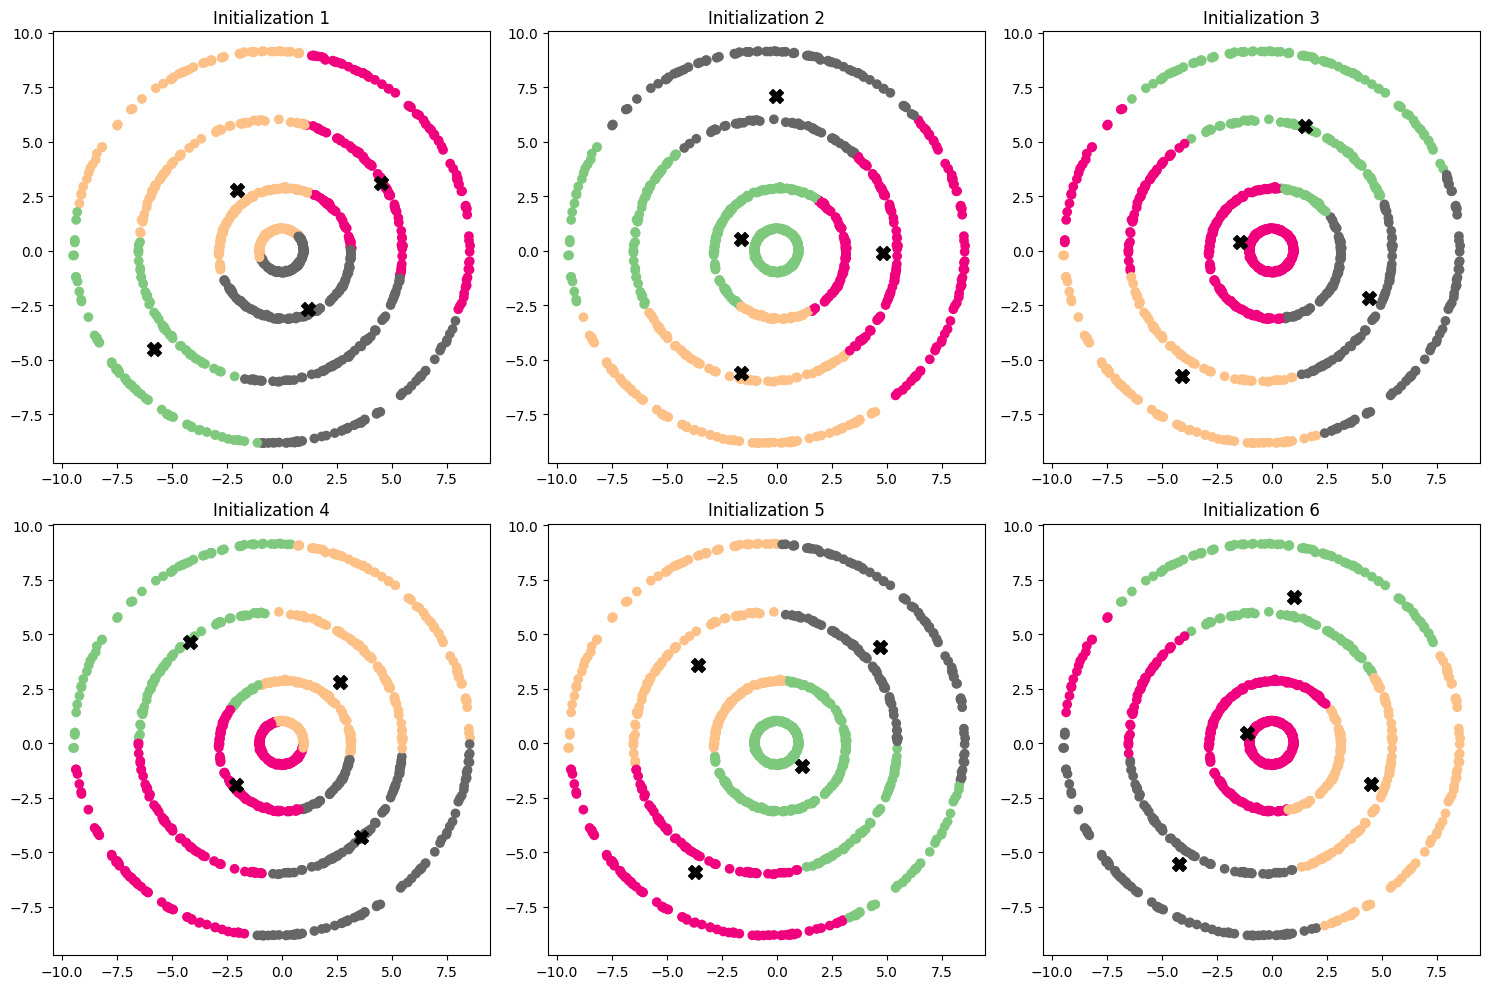

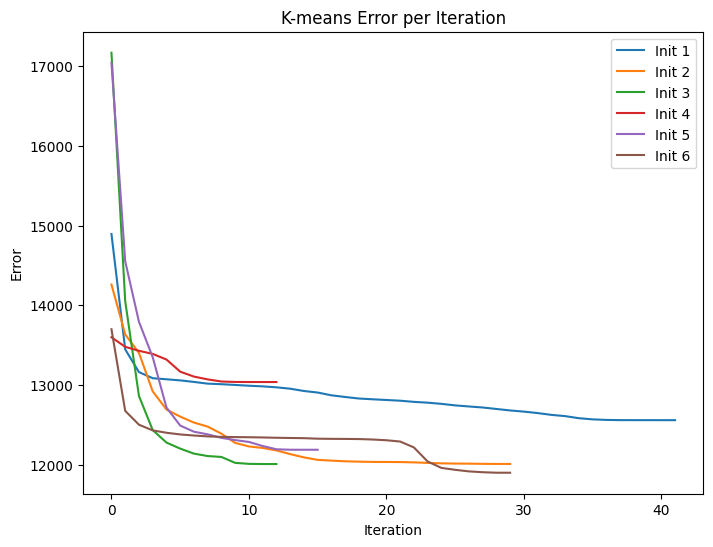

In [5]:
plt.figure(figsize=(15, 10))
for i, seed in enumerate(seeds):
    km = KMeansFromScratch(k=4)
    km.fit(data, init_seed=seed)
    plt.subplot(2, 3, i+1)
    plt.scatter(data[:,0], data[:,1], c=km.labels, cmap='Accent')
    plt.scatter(km.centroids[:,0], km.centroids[:,1], color='black', marker='X', s=100)
    plt.title(f'Initialization {i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i, seed in enumerate(seeds):
    km = KMeansFromScratch(k=4)
    km.fit(data, init_seed=seed)
    plt.plot(km.error_history, label=f'Init {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('K-means Error per Iteration')
plt.legend()
plt.show()

# Part B

## Using scipy

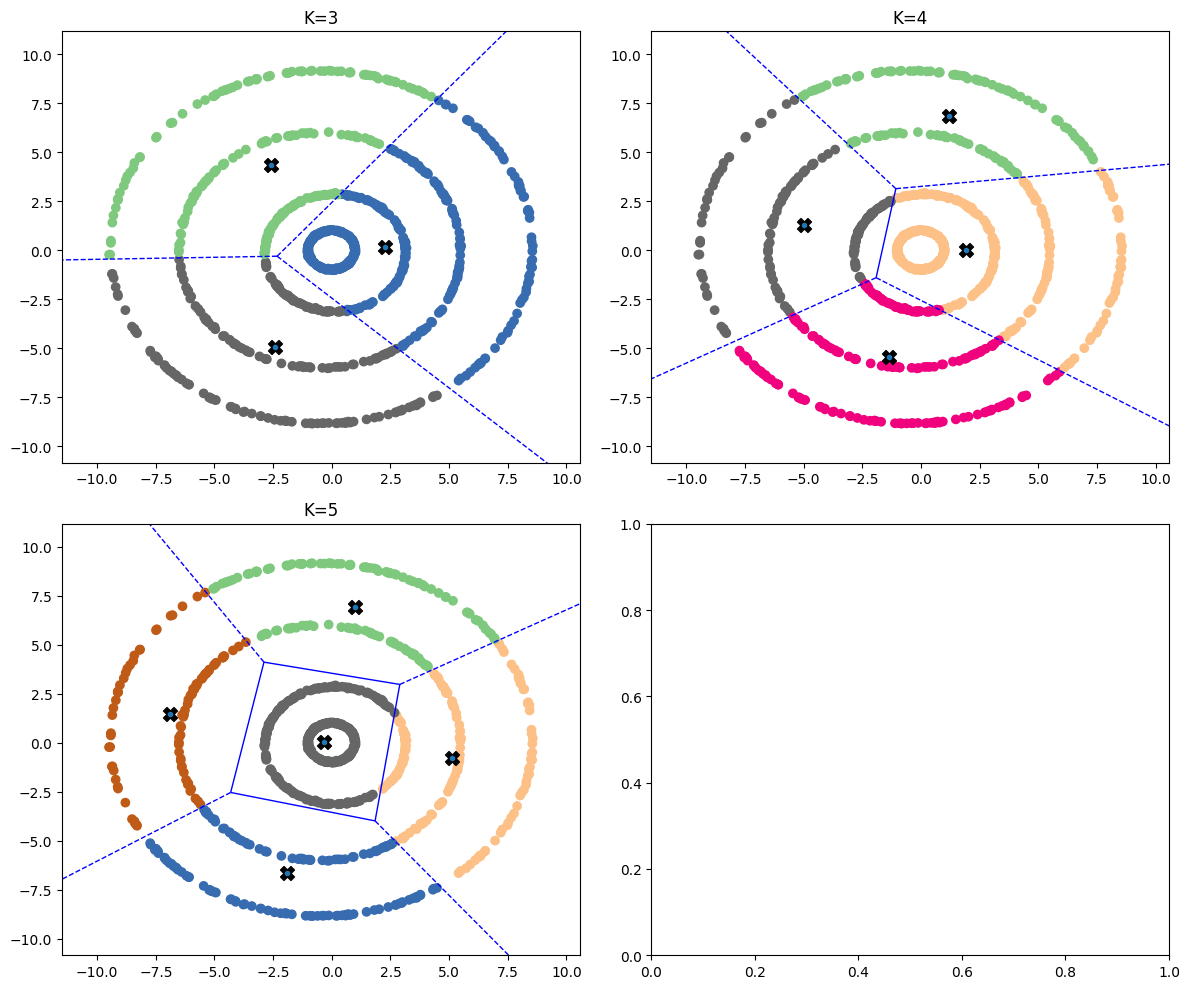

In [6]:
from scipy.spatial import Voronoi, voronoi_plot_2d

seed = 42
Ks = [3, 4, 5]
xmin, xmax = data[:, 0].min() - 2, data[:, 0].max() + 2
ymin, ymax = data[:, 1].min() - 2, data[:, 1].max() + 2

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, k in enumerate(Ks):
    km = KMeansFromScratch(k=k)
    km.fit(data, init_seed=seed)
    ax = axes.flat[idx]
    # Voronoi using centroids
    points = km.centroids
    vor = Voronoi(points)
    voronoi_plot_2d(vor, ax=ax, show_points=True, show_vertices=False, line_colors='blue')
    ax.scatter(data[:,0], data[:,1], c=km.labels, cmap='Accent')
    ax.scatter(points[:,0], points[:,1], color='black', marker='X', s=100)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(f'K={k}')
plt.tight_layout()
plt.show()


## Manually

In [7]:
def plot_voronoi_regions_manual(centroids, X, labels, x_range, y_range, ax, title):
    x_min, x_max = x_range
    y_min, y_max = y_range
    
    # Create grid
    resolution = 200
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Assign grid points to nearest centroid
    distances = np.zeros((len(centroids), len(grid_points)))
    for i, centroid in enumerate(centroids):
        distances[i] = np.linalg.norm(grid_points - centroid, axis=1)
    regions = np.argmin(distances, axis=0).reshape(xx.shape)
    
    # Plot regions
    colors = plt.cm.Set3(np.linspace(0, 1, len(centroids)))
    ax.contourf(xx, yy, regions, levels=len(centroids)-1, colors=colors, alpha=0.3)
    ax.contour(xx, yy, regions, levels=len(centroids)-1, colors='black', linewidths=1)
    
    # Plot data and centroids
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='Set1', s=30, alpha=0.8, edgecolors='black')
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, edgecolors='black')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

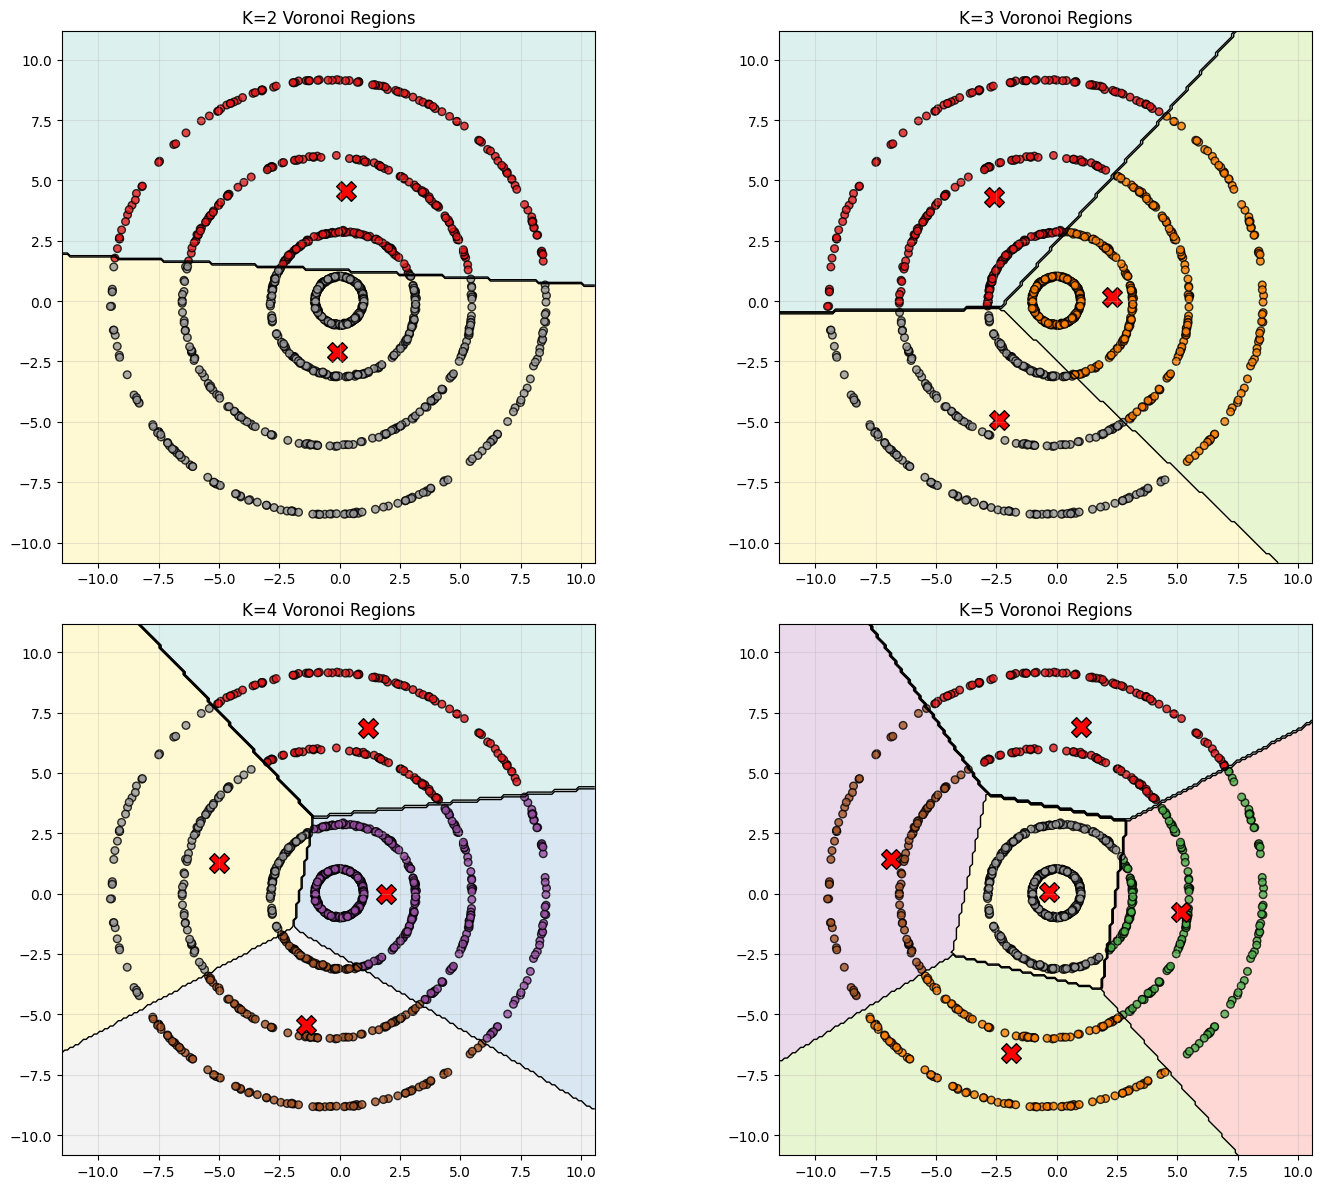

In [8]:
fixed_seed = 42
k_values = [2, 3, 4, 5]
x_range = (data[:, 0].min() - 2, data[:, 0].max() + 2)
y_range = (data[:, 1].min() - 2, data[:, 1].max() + 2)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    kmeans = KMeansFromScratch(k=k)
    kmeans.fit(data, init_seed=fixed_seed)
    plot_voronoi_regions_manual(kmeans.centroids, data, kmeans.labels, x_range, y_range, axes[idx], f'K={k} Voronoi Regions')

plt.tight_layout()
plt.show()

# Part C

In [9]:
class SpectralClusteringFromScratch:
    def __init__(self, k=4, kernel='rbf', sigma=1):
        self.k = k
        self.kernel = kernel
        self.sigma = sigma
        self.labels = None
        self.eigenvalues = None
        self.eigenvectors = None
    
    def compute_kernel_matrix(self, X):
        if self.kernel == 'rbf':
            pairwise_sq_dists = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2)
            return np.exp(-pairwise_sq_dists/(2*(self.sigma**2)))
        elif self.kernel == 'linear':
            return np.dot(X, X.T)
        elif self.kernel == 'quadratic':
            print('quadratic')
            return (np.dot(X, X.T)+1)**2
        elif self.kernel == 'cubic':
            return (np.dot(X, X.T)+1)**3
    
    def normalize(self, W):
        length = np.linalg.norm(W, axis=1, keepdims=True)
        # Prevent division by zero using np.maximum
        length_safe = np.maximum(length, 1e-12)
        return W / length_safe
    
    def fit(self, X, seed = None):
        K = self.compute_kernel_matrix(X)
        eigenvals, eigenvecs = np.linalg.eigh(K)
        
        H = eigenvecs[:,-self.k:]
        new_dataset = self.normalize(H)
        
        # Use sklearn KMeans to avoid numerical issues
        kmeans = KMeansFromScratch(k=self.k)
        kmeans.fit(new_dataset, init_seed=seed)
        self.labels = kmeans.labels
        return self


In [10]:
sigmas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 4, 5, 10]

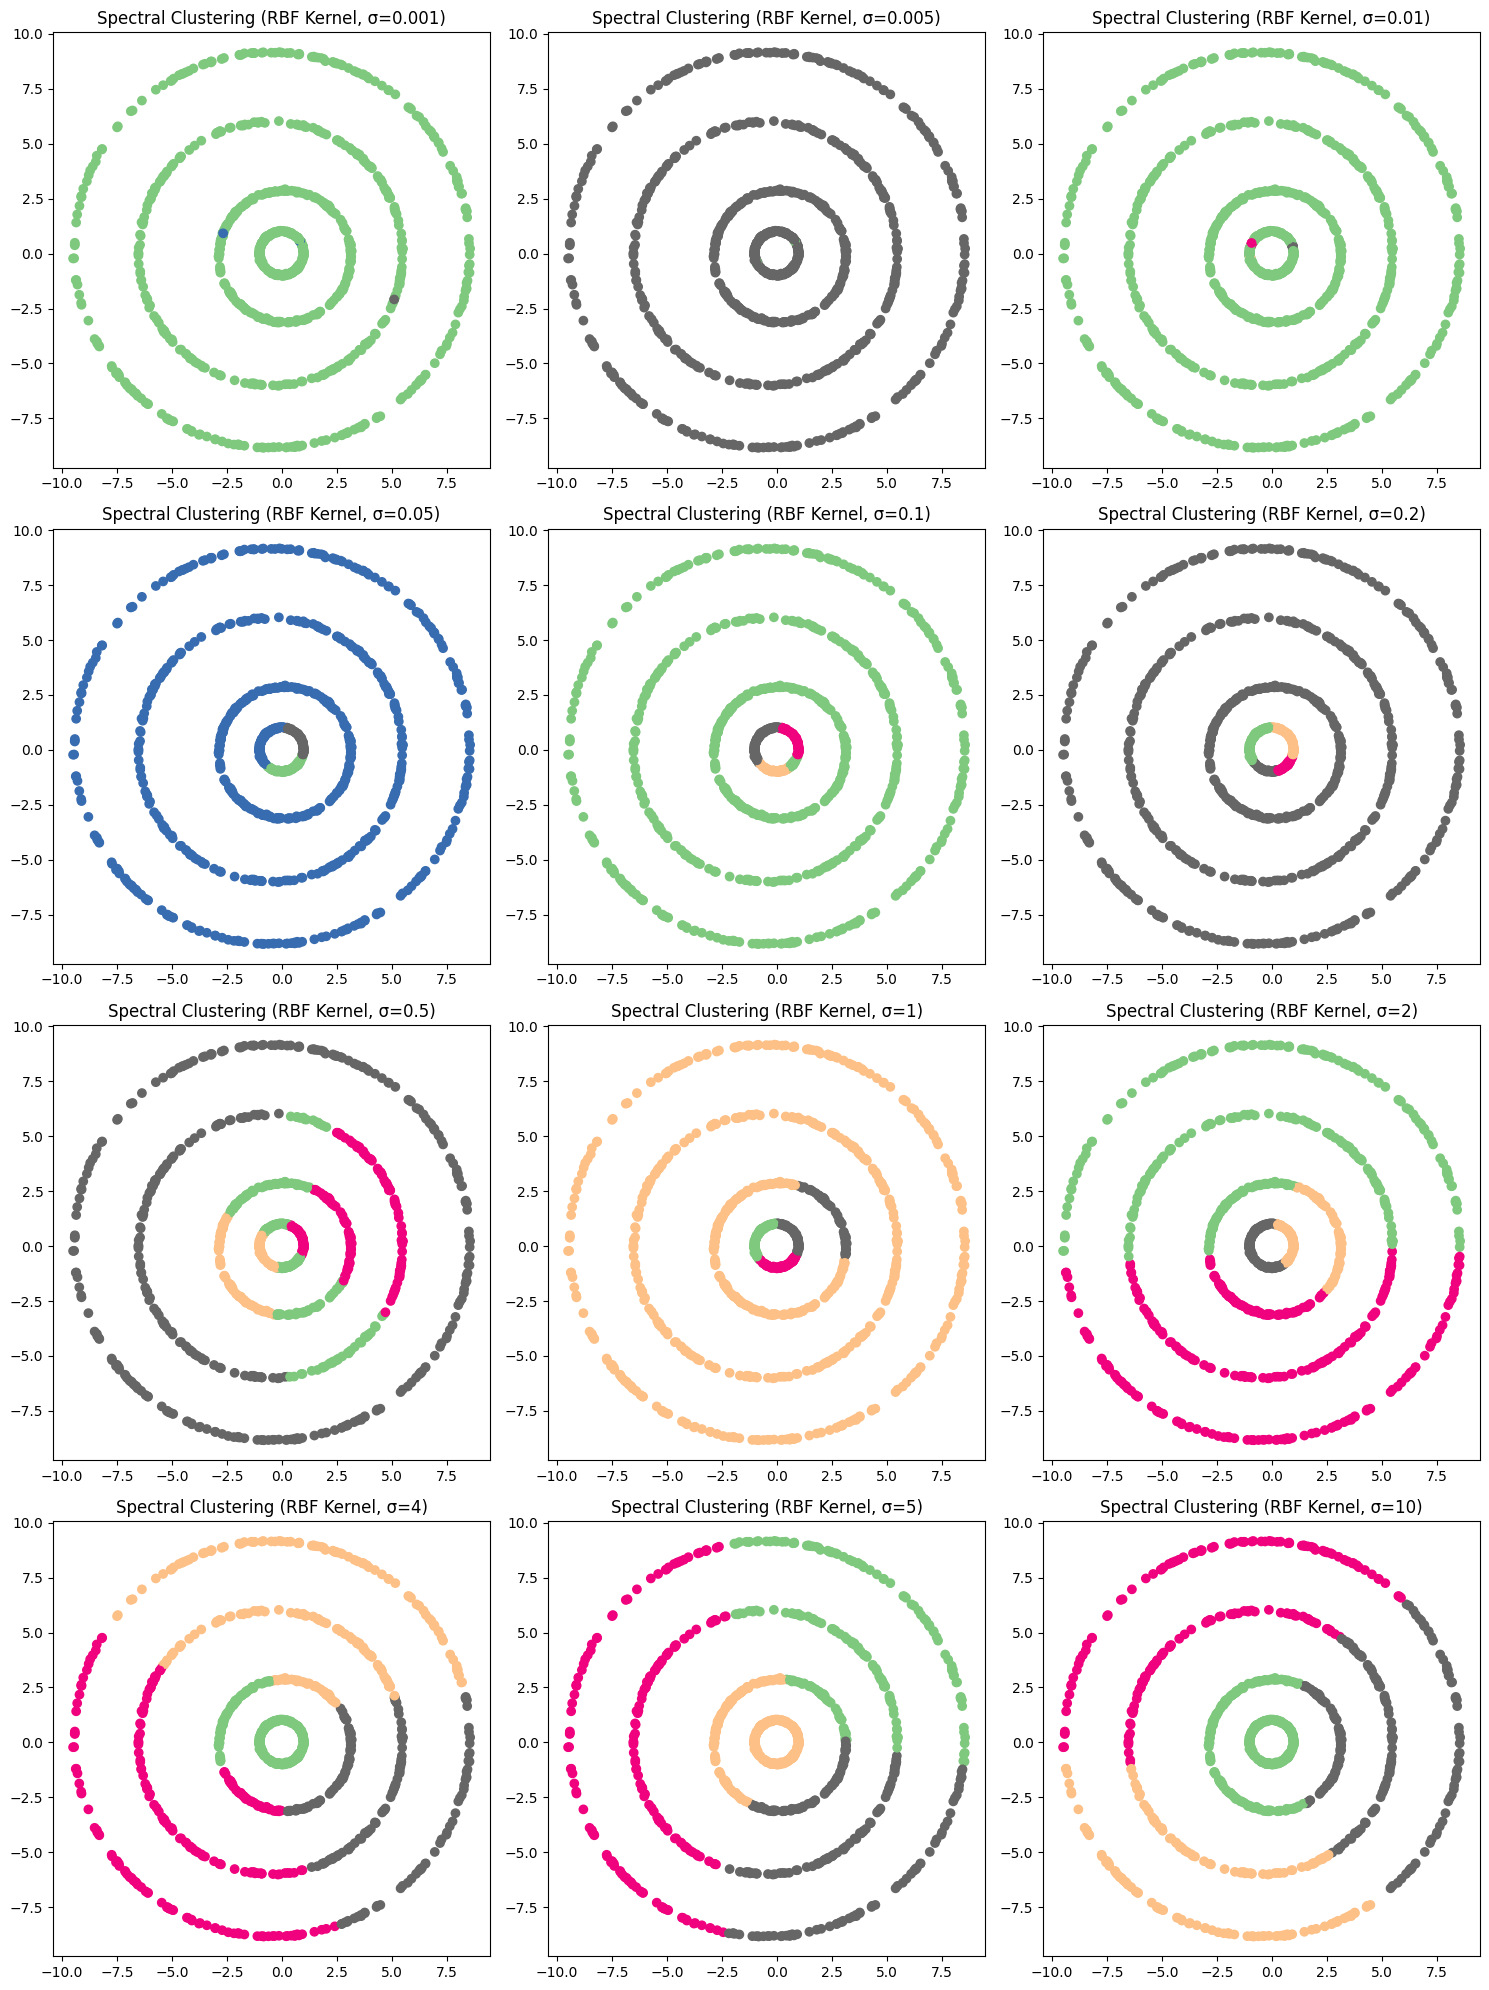

In [11]:
plt.figure(figsize=(15, 20))
for i, sigma in enumerate(sigmas):
    spectral_rbf = SpectralClusteringFromScratch(k=4, kernel='rbf', sigma=sigma)
    spectral_rbf.fit(data)
    plt.subplot(4, 3, i+1)
    plt.scatter(data[:,0], data[:,1], c=spectral_rbf.labels, cmap='Accent')
    plt.title(f'Spectral Clustering (RBF Kernel, σ={sigma})')
plt.tight_layout()
plt.show()

quadratic


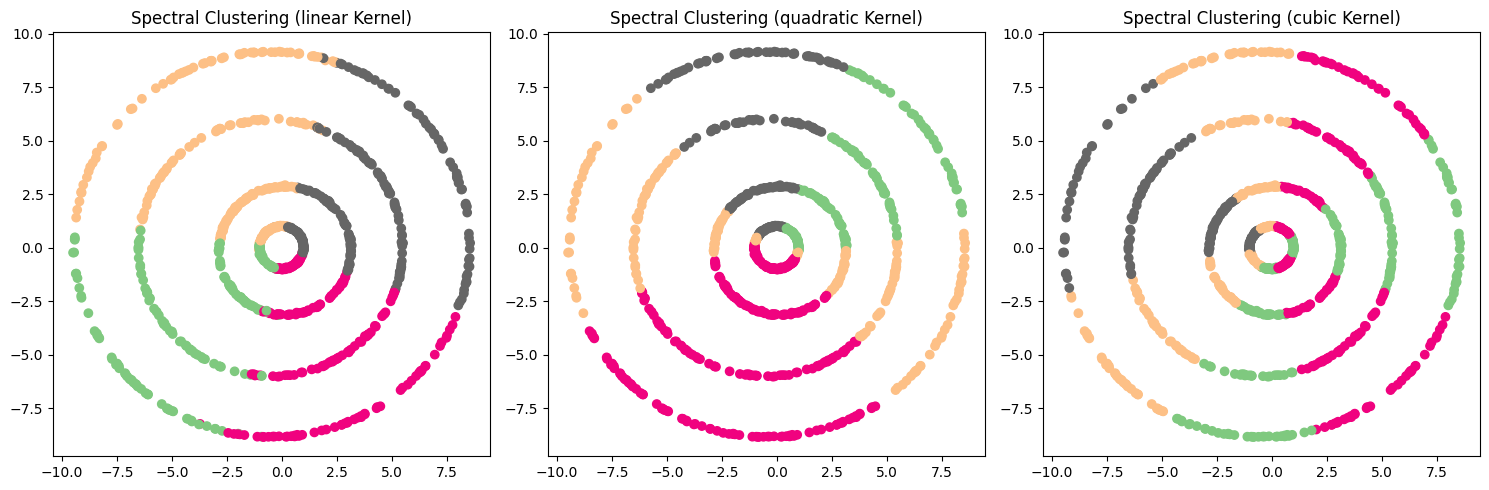

In [12]:
kernels = ['linear', 'quadratic', 'cubic']

plt.figure(figsize=(15, 5))
for i, kernel in enumerate(kernels):
    spectral_rbf = SpectralClusteringFromScratch(k=4, kernel=kernel, sigma=1)
    spectral_rbf.fit(data)
    plt.subplot(1, 3, i+1)
    plt.scatter(data[:,0], data[:,1], c=spectral_rbf.labels, cmap='Accent')
    plt.title(f'Spectral Clustering ({kernel} Kernel)')
plt.tight_layout()
plt.show()

## Modified with Laplacian

In [13]:
class SpectralClusteringFromScratch_Modified:
    def __init__(self, k=4, kernel='rbf', sigma=1):
        self.k = k
        self.kernel = kernel
        self.sigma = sigma
        self.labels = None
        self.eigenvalues = None
        self.eigenvectors = None
    
    def compute_kernel_matrix(self, X):
        if self.kernel == 'rbf':
            pairwise_sq_dists = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2)
            return np.exp(-pairwise_sq_dists/(2*(self.sigma**2)))
        elif self.kernel == 'linear':
            return np.dot(X, X.T)
        elif self.kernel == 'quadratic':
            return (np.dot(X, X.T)+1)**2
        elif self.kernel == 'cubic':
            return (np.dot(X, X.T)+1)**3
    
    def compute_laplacian(self, W):
        # Ensure W is clean (no NaN/inf)
        W = np.where(np.isfinite(W), W, 0.0)
        
        # Compute degree matrix with safety check
        degrees = np.sum(W, axis=1)
        degrees_safe = np.maximum(degrees, 1e-12)  # Prevent zero degrees
        
        # Compute D^(-1/2) safely
        inv_sqrt_degrees = 1.0 / np.sqrt(degrees_safe)
        D_sqrt_inv = np.diag(inv_sqrt_degrees)
        
        # Compute normalized Laplacian
        L = np.eye(W.shape[0]) - D_sqrt_inv @ W @ D_sqrt_inv
        
        # Final safety check
        L = np.where(np.isfinite(L), L, 0.0)
        
        return L
    
    def normalize(self, W):
        length = np.linalg.norm(W, axis=1, keepdims=True)
        # Prevent division by zero using np.maximum
        length_safe = np.maximum(length, 1e-12)
        return W / length_safe
    
    def fit(self, X, seed = None):
        K = self.compute_kernel_matrix(X)
        L = self.compute_laplacian(K)

        eigenvals, eigenvecs = np.linalg.eigh(L)
        
        H = eigenvecs[:,-self.k:]
        new_dataset = self.normalize(H)
        
        # Use sklearn KMeans to avoid numerical issues
        kmeans = KMeansFromScratch(k=self.k)
        kmeans.fit(new_dataset, init_seed=seed)
        self.labels = kmeans.labels
        return self


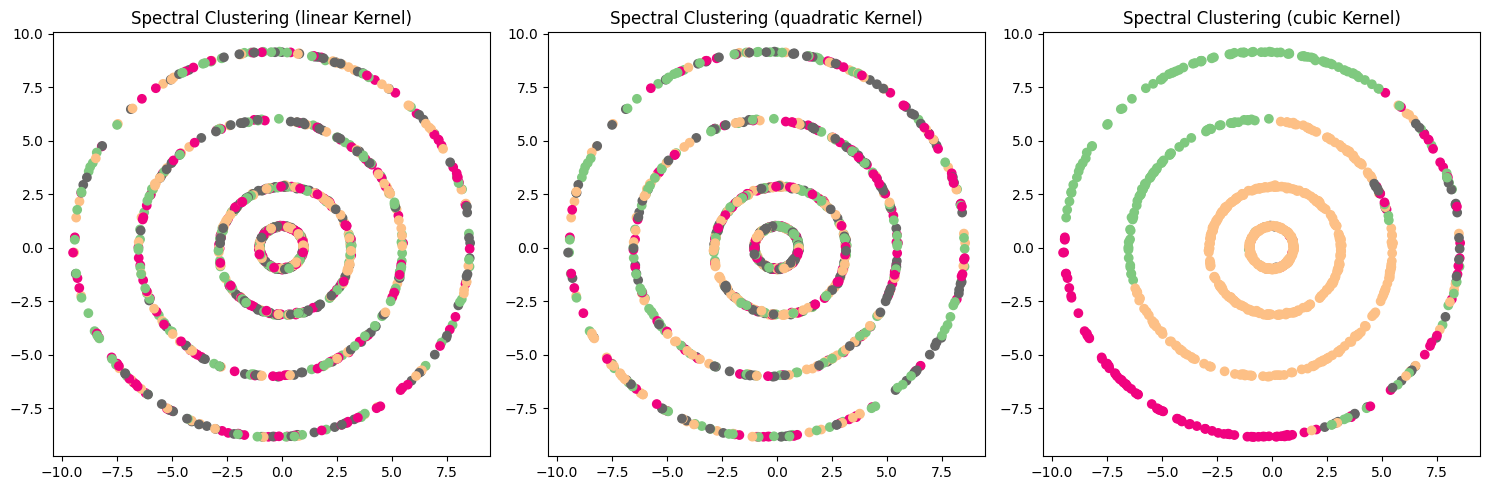

In [14]:
kernels = ['linear', 'quadratic', 'cubic']

plt.figure(figsize=(15, 5))
for i, kernel in enumerate(kernels):
    spectral_rbf = SpectralClusteringFromScratch_Modified(k=4, kernel=kernel, sigma=1)
    spectral_rbf.fit(data)
    plt.subplot(1, 3, i+1)
    plt.scatter(data[:,0], data[:,1], c=spectral_rbf.labels, cmap='Accent')
    plt.title(f'Spectral Clustering ({kernel} Kernel)')
plt.tight_layout()
plt.show()

# Part D

In [15]:
class SpectralClusteringFromScratch_Maximum:
    def __init__(self, k=4, kernel='rbf', sigma=1):
        self.k = k
        self.kernel = kernel
        self.sigma = sigma
        self.labels = None
        self.eigenvalues = None
        self.eigenvectors = None
    
    def compute_kernel_matrix(self, X):
        if self.kernel == 'rbf':
            pairwise_sq_dists = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2)
            return np.exp(-pairwise_sq_dists/(2*(self.sigma**2)))
        elif self.kernel == 'linear':
            return np.dot(X, X.T)
        elif self.kernel == 'quadratic':
            return (np.dot(X, X.T)+1)**2
        elif self.kernel == 'cubic':
            return (np.dot(X, X.T)+1)**3
    
    def maximize(self, W):
        dataset = np.zeros(W.shape)
        idxs = np.argmax(W, axis=1)

        for i, ind in enumerate(idxs):
            dataset[i, ind] = 1
        
        return dataset

    def fit(self, X, seed = None):
        K = self.compute_kernel_matrix(X)

        eigenvals, eigenvecs = np.linalg.eigh(K)
        
        H = eigenvecs[:,-self.k:]
        new_dataset = self.maximize(H)
        
    
        # Use sklearn KMeans to avoid numerical issues
        kmeans = KMeansFromScratch(k=self.k)
        kmeans.fit(new_dataset, init_seed=seed)
        self.labels = kmeans.labels
        return self


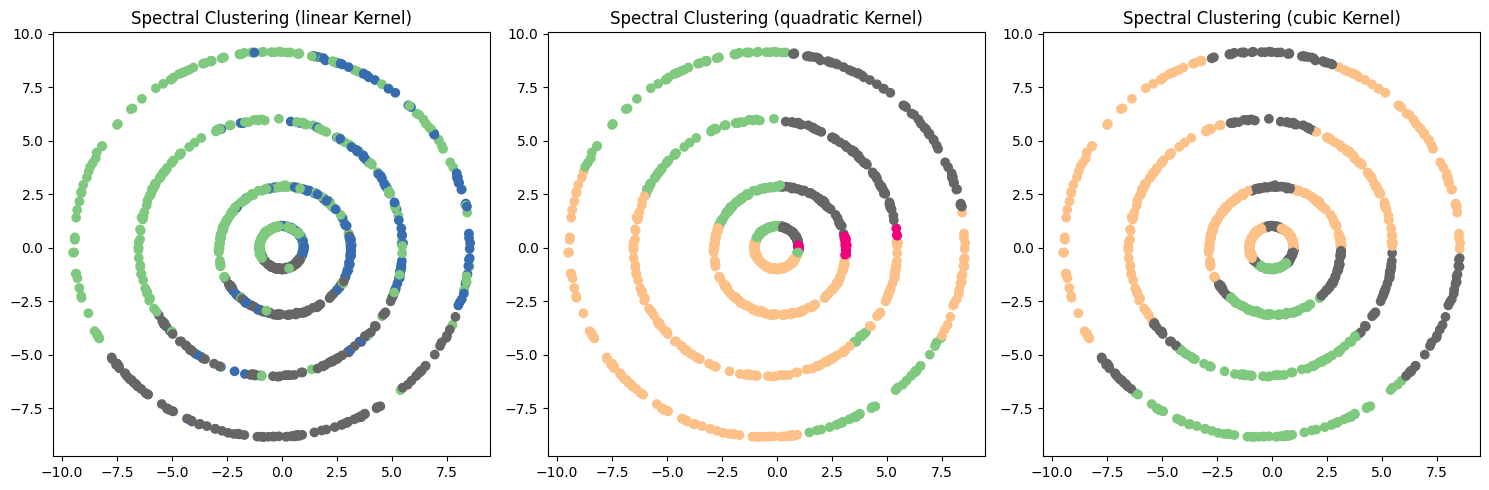

In [16]:
kernels = ['linear', 'quadratic', 'cubic']

plt.figure(figsize=(15, 5))
for i, kernel in enumerate(kernels):
    spectral_rbf = SpectralClusteringFromScratch_Maximum(k=4, kernel=kernel, sigma=1)
    spectral_rbf.fit(data)
    plt.subplot(1, 3, i+1)
    plt.scatter(data[:,0], data[:,1], c=spectral_rbf.labels, cmap='Accent')
    plt.title(f'Spectral Clustering ({kernel} Kernel)')
plt.tight_layout()
plt.show()

In [17]:
class SpectralClusteringFromScratch_Maximum_Modified:
    def __init__(self, k=4, kernel='rbf', sigma=1):
        self.k = k
        self.kernel = kernel
        self.sigma = sigma
        self.labels = None
        self.eigenvalues = None
        self.eigenvectors = None
    
    def compute_kernel_matrix(self, X):
        if self.kernel == 'rbf':
            pairwise_sq_dists = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2)
            return np.exp(-pairwise_sq_dists/(2*(self.sigma**2)))
        elif self.kernel == 'linear':
            return np.dot(X, X.T)
        elif self.kernel == 'quadratic':
            return (np.dot(X, X.T)+1)**2
        elif self.kernel == 'cubic':
            return (np.dot(X, X.T)+1)**3
    
    def maximize(self, W):
        dataset = np.zeros(W.shape)
        idxs = np.argmax(W, axis=1)

        for i, ind in enumerate(idxs):
            dataset[i, ind] = 1
        
        return dataset
    
    def compute_laplacian(self, W):
        # Ensure W is clean (no NaN/inf)
        W = np.where(np.isfinite(W), W, 0.0)
        
        # Compute degree matrix with safety check
        degrees = np.sum(W, axis=1)
        degrees_safe = np.maximum(degrees, 1e-12)  # Prevent zero degrees
        
        # Compute D^(-1/2) safely
        inv_sqrt_degrees = 1.0 / np.sqrt(degrees_safe)
        D_sqrt_inv = np.diag(inv_sqrt_degrees)
        
        # Compute normalized Laplacian
        L = np.eye(W.shape[0]) - D_sqrt_inv @ W @ D_sqrt_inv
        
        # Final safety check
        L = np.where(np.isfinite(L), L, 0.0)
        
        return L
    
    def fit(self, X, seed = None):
        K = self.compute_kernel_matrix(X)
        L = self.compute_laplacian(K)

        eigenvals, eigenvecs = np.linalg.eigh(L)
        
        H = eigenvecs[:,-self.k:]
        new_dataset = self.maximize(H)
        
        # Use sklearn KMeans to avoid numerical issues
        kmeans = KMeansFromScratch(k=self.k)
        kmeans.fit(new_dataset, init_seed=seed)
        self.labels = kmeans.labels
        return self


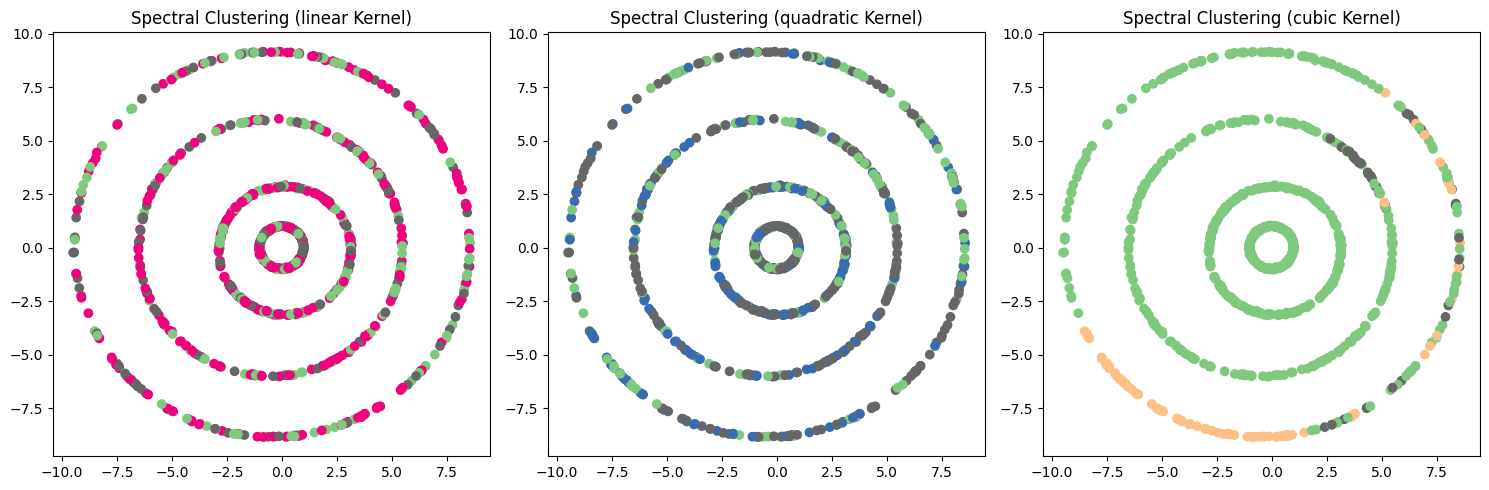

In [18]:
kernels = ['linear', 'quadratic', 'cubic']

plt.figure(figsize=(15, 5))
for i, kernel in enumerate(kernels):
    spectral_rbf = SpectralClusteringFromScratch_Maximum_Modified(k=4, kernel=kernel, sigma=1)
    spectral_rbf.fit(data)
    plt.subplot(1, 3, i+1)
    plt.scatter(data[:,0], data[:,1], c=spectral_rbf.labels, cmap='Accent')
    plt.title(f'Spectral Clustering ({kernel} Kernel)')
plt.tight_layout()
plt.show()